In [1]:
## Import necessary libraries to perform EDA & Model Building
import sys
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score
from numpy import arange
from math import sqrt

warnings.filterwarnings('ignore')
%matplotlib inline

pd.set_option("display.max_columns", None)

In [2]:
# Read data from cvs file
data = pd.read_csv('train_adv_reg.csv')

In [3]:
# See the deminsion of data
data.shape

(1460, 81)

In [4]:
# See ifnormation of data, whether missing vlaues are there
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
null = pd.DataFrame(round(data.isnull().sum()/len(data.index)*100,2).sort_values(ascending=False),columns=["Null %"])
null.index.name = 'Variables'
null.head(20)

,Null %
Variables,
PoolQC,99.52
MiscFeature,96.30
Alley,93.77
Fence,80.75
FireplaceQu,47.26
LotFrontage,17.74
GarageYrBlt,5.55
GarageCond,5.55
GarageType,5.55


In [6]:
## Variables like PoolQC, MiscFeature, Alley, Fence, FireplaceQu have high missing values, let's drop them along with ID

data = data.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'Id', 'FireplaceQu'], axis='columns')
data.shape

(1460, 75)

In [7]:
# Categorical columns
data.select_dtypes(include='object').columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [8]:
# Numeric columns
data.select_dtypes(exclude='object').columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [9]:
data['LotFrontage'] = data['LotFrontage'].fillna(data['LotFrontage'].median())
data['GarageYrBlt'] = data['GarageYrBlt'].fillna(data['GarageYrBlt'].median())

# for the "below columns" we will impute the null values with 'mode'
for col in ('GarageCond', 'GarageType', 'GarageFinish','GarageQual', 'BsmtExposure', 'BsmtFinType2',
            'BsmtFinType1','BsmtCond','BsmtQual', 'MasVnrArea', 'MasVnrType', 'Electrical'):
    
    data[col] = data[col].fillna(data[col].mode()[0])


In [10]:
# checking for the presence of any more null values
data.isnull().values.any()

False

In [11]:
num=['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond','YearBuilt', 'YearRemodAdd',
     'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
     'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
     'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
     'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.1)  
sel.fit(data[num])
quasi_constant = data[num].columns[~sel.get_support()]

quasi_constant

Index(['BsmtHalfBath', 'KitchenAbvGr'], dtype='object')

In [12]:
data['BsmtHalfBath'].value_counts() / np.float(len(data))

0    0.943836
1    0.054795
2    0.001370
Name: BsmtHalfBath, dtype: float64

In [13]:
data['KitchenAbvGr'].value_counts() / np.float(len(data))

1    0.953425
2    0.044521
3    0.001370
0    0.000685
Name: KitchenAbvGr, dtype: float64

In [14]:
data.drop(['BsmtHalfBath', 'KitchenAbvGr'], axis=1, inplace=True)

In [15]:
data.shape

(1460, 73)

In [16]:
# Convert categorical value into Dummy variable
data=pd.get_dummies(data,drop_first=True)
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,2,1,3,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0

In [17]:
#Split the data into train and test
y = data.pop('SalePrice')
X = data
#import train_test_split to split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print('X_train shape',X_train.shape)
print('X_test shape',X_test.shape)
print('y_train shape',y_train.shape)
print('y_test shape',y_test.shape)

X_train shape (978, 230)
X_test shape (482, 230)
y_train shape (978,)
y_test shape (482,)


In [18]:
# columns to be scaled
num_vars=X_train.select_dtypes(include=['int64','int32','float64','float32']).columns
num_vars

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

In [19]:
#Scaling using MinMax
from sklearn.preprocessing import StandardScaler,MinMaxScaler
#scaler = StandardScaler()
scaler=MinMaxScaler()
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

In [20]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [21]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, step=25)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [22]:
col = X_train.columns[rfe.support_]
col

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       ...
       'GarageQual_TA', 'GarageCond_Fa', 'GarageCond_Gd', 'GarageCond_Po',
       'GarageCond_TA', 'SaleType_Con', 'SaleType_ConLI',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Partial'],
      dtype='object', length=115)

In [23]:
rfe_scores = pd.DataFrame(list(zip(X_train.columns, rfe.support_,rfe.ranking_)))
rfe_scores.columns = ['Column_Names','Status','Rank']

rfe_sel_columns = list(rfe_scores[rfe_scores.Status==True].Column_Names)

len(rfe_sel_columns)

115

In [24]:
#Check the shape of train and test
X_train1=X_train[col]
X_test1=X_test[col]
print(X_train1.shape)
print(X_test1.shape)
print(y_train.shape)
print(y_test.shape)

(978, 115)
(482, 115)
(978,)
(482,)


In [25]:
lm1=lm.fit(X_train, y_train)

In [26]:
#import libraries for model evalution
from sklearn.metrics import r2_score, mean_squared_error

In [27]:
#r2score,RSS and RMSE
y_pred_train = rfe.predict(X_train)
y_pred_test = rfe.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

0.9216527483549108
-5.919484560180094e+18
444175158648.4629
2.0946395854067303e+31
454166828.88390887
4.345725280926826e+28


In [28]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

In [29]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
                    4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


ridge = Ridge()

# cross validation
folds = 10
ridge_model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
ridge_model_cv.fit(X_train1, y_train) 

Fitting 10 folds for each of 28 candidates, totalling 280 fits


GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [30]:
print(ridge_model_cv.best_params_)
print(ridge_model_cv.best_score_)

{'alpha': 0.1}
-19084.175268404077


In [31]:
alpha = 0.1
ridge = Ridge(alpha=alpha)
ridge.fit(X_train1, y_train)

Ridge(alpha=0.1)

In [32]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train1)
y_pred_test = ridge.predict(X_test1)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.9101566463170867
0.8329242147696831
509350169121.3353
591206126054.4742
520807943.88684595
1226568726.254096


In [33]:
lasso = Lasso()

# cross validation
lasso_model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_model_cv.fit(X_train1, y_train)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


GridSearchCV(cv=10, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [34]:
print(lasso_model_cv.best_params_)
print(lasso_model_cv.best_score_)

{'alpha': 20}
-18775.86627320022


In [35]:
alpha = 20

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train1, y_train) 

Lasso(alpha=20)

In [36]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train1)
y_pred_test = lasso.predict(X_test1)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.9127942077463865
0.8190564424944633
494397005587.1329
640277940456.1621
505518410.62079024
1328377469.8260624


In [37]:
betas = pd.DataFrame(index=X_train1.columns)
betas.rows = X_train1.columns
betas['Lasso'] = lasso.coef_
pd.set_option('display.max_rows', None)
betas.head(5)

,Lasso
LotArea,91186.654449
OverallQual,95523.076295
OverallCond,43560.850663
YearBuilt,59375.021225
MasVnrArea,32923.080003


In [38]:
ridge_pred = ridge.predict(X_test1)

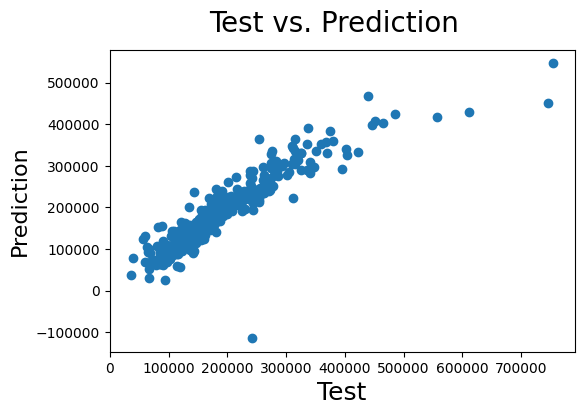

In [39]:
# Plotting y_test and y_pred to understand the spread for ridge regression.
fig = plt.figure(dpi=100)
plt.scatter(y_test, ridge_pred)
fig.suptitle('Test vs. Prediction', fontsize=20)              # Plot heading 
plt.xlabel('Test', fontsize=18)                              # X-label
plt.ylabel('Prediction', fontsize=16)  
plt.show()

In [40]:
betas = pd.DataFrame(index=X_train1.columns)
betas.rows = X_train1.columns
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_
pd.set_option('display.max_rows', None)

In [41]:
betas.head(50)

,Ridge,Lasso
LotArea,98690.763001,91186.654449
OverallQual,94344.497727,95523.076295
OverallCond,42170.666492,43560.850663
YearBuilt,58863.569268,59375.021225
MasVnrArea,34605.672287,32923.080003
BsmtFinSF1,47760.921972,62325.672122
BsmtFinSF2,9856.776542,7525.019141
BsmtUnfSF,-150.891651,-0.000000
TotalBsmtSF,45878.682140,43280.781225
1stFlrSF,106320.065880,25009.438150


In [42]:
# Change the alpha value from 0.1 to 0.2
alpha = 0.2
ridge2 = Ridge(alpha=alpha)
ridge2.fit(X_train1, y_train)
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge2.predict(X_train1)
y_pred_test = ridge2.predict(X_test1)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.9013741388980946
0.8455744003572537
559140960045.7374
546442803800.5164
571718773.0529013
1133698763.071611


In [43]:
# Change the alpha value from 20 to 40
alpha = 40
lasso2 = Lasso(alpha=alpha)
lasso2.fit(X_train1, y_train) 
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = lasso2.predict(X_train1)
y_pred_test = lasso2.predict(X_test1)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.8954334877120486
0.8514521616696995
592820376076.6958
525644047771.24744
606155803.7594026
1090547816.9527955


In [44]:
# important predictor variables
betas = pd.DataFrame(index=X_train1.columns)
betas.rows = X_train1.columns
betas['Ridge'] = ridge.coef_
betas['Ridge2'] = ridge2.coef_
betas['Lasso'] = lasso.coef_
betas['Lasso2'] = lasso2.coef_
pd.set_option('display.max_rows', None)
betas.head(20)

,Ridge,Ridge2,Lasso,Lasso2
LotArea,98690.763001,77738.162689,91186.654449,59867.874536
OverallQual,94344.497727,99291.297783,95523.076295,110278.721897
OverallCond,42170.666492,40355.209985,43560.850663,38178.966928
YearBuilt,58863.569268,55177.906916,59375.021225,50199.920815
MasVnrArea,34605.672287,35614.018211,32923.080003,34093.948546
BsmtFinSF1,47760.921972,33277.250645,62325.672122,32024.969523
BsmtFinSF2,9856.776542,8870.660622,7525.019141,2913.312893
BsmtUnfSF,-150.891651,-73.784759,-0.000000,-0.000000
TotalBsmtSF,45878.682140,32347.246475,43280.781225,2306.955727
1stFlrSF,106320.065880,100122.845617,25009.438150,38482.386630


In [45]:
X_train2 = X_train1.drop(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'MasVnrArea'],axis=1)
X_test2 = X_test1.drop(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'MasVnrArea'],axis=1)

In [46]:
alpha = 20
lasso3 = Lasso(alpha=alpha)
lasso3.fit(X_train2, y_train) 

# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = lasso3.predict(X_train2)
y_pred_test = lasso3.predict(X_test2)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.8899219017477835
0.7923804867200408
624067286704.4218
734672160722.4698
638105610.1272206
1524216101.0839624


In [47]:
#important predictor variables
betas = pd.DataFrame(index=X_train2.columns)
betas.rows = X_train2.columns
betas['Lasso3'] = lasso3.coef_
pd.set_option('display.max_rows', None)
betas.head(10)

,Lasso3
BsmtFinSF1,70840.378539
BsmtFinSF2,6435.731961
BsmtUnfSF,-0.000000
TotalBsmtSF,82641.693844
1stFlrSF,102436.738310
2ndFlrSF,33871.333531
LowQualFinSF,-7345.247601
GrLivArea,168194.253383
BsmtFullBath,17801.813037
FullBath,22271.288867
